# Inallation and Configuration + Imports

In [ ]:
!git clone https://github.com/openai/shap-e

Cloning into 'shap-e'...
remote: Enumerating objects: 330, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 330 (delta 32), reused 17 (delta 15), pack-reused 281
Receiving objects: 100% (330/330), 11.71 MiB | 11.51 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [ ]:
%cd shap-e
!pip install -e .

/content/shap-e
Obtaining file:///content/shap-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-60_t2uvl/clip_d7c2571cd4f24dad919d624305f07fb4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-60_t2uvl/clip_d7c2571cd4f24dad919d624305f07fb4
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.7 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369499 sha256=74993d015f91ef46385799e8298bf84b1dc9a0ec2843a19922880680f39138cc


In [ ]:
import torch
import cv2
from PIL import Image
import math
# !pip install anvil-uplink
import anvil.server
anvil.server.connect('FDECFLFLG374CA5YI7T7XHAC-QBBJKXJK6PJ54CKO-CLIENT')
import io

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from shap_e.util.image_util import load_image

In [ ]:
!pip install anvil-uplink # backend with frontend Link
import anvil.server

# Image to 3D

## Backend Code

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
xm = load_model('transmitter', device=device)
model = load_model('image300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))
batch_size = 4
guidance_scale = 3.0

  0%|          | 0.00/1.26G [00:00<?, ?iB/s]

In [ ]:
@anvil.server.callable  # Hier wird Anvil sich die Funktionen holen
def process_image_remote(image):
  cv2.imwrite(f'/content/input_image.jpg', image)
  # To get the best result, you should remove the background and show only the object of interest to the model.
  image = load_image("/content/input_image.jpg")

  latents = sample_latents(
      batch_size=batch_size,
      model=model,
      diffusion=diffusion,
      guidance_scale=guidance_scale,
      model_kwargs=dict(images=[image] * batch_size),
      progress=True,
      clip_denoised=True,
      use_fp16=True,
      use_karras=True,
      karras_steps=64,
      sigma_min=1e-3,
      sigma_max=160,
      s_churn=0,
  )

  render_mode = 'nerf' # you can change this to 'stf' for mesh rendering
  size = 64 # this is the size of the renders; higher values take longer to render.

  cameras = create_pan_cameras(size, device)
  for i, latent in enumerate(latents):
      images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
      # display(gif_widget(images))
      img = gif_widget(images)
      gif_path = r'/content/gif_image.gif'
      cv2.imwrite(f'{gif_path}', img)
      # extract different poses from the gif image and convert to multiple .png or .jpg images
      with Image.open(gif_path) as im:
          steps = im.n_frames*0.25
          steps = math.floor(steps)
          print(steps)
          for i in range(0, im.n_frames, int(steps)):
              im.seek(i)
              im.save(f"/content/frame_{i}.jpg")

  name = 'Flippedimage'
  img = r"/content/frame_0.jpg"
  img = Image.open(img)
  bs = io.BytesIO(b'img2') # lädt die Daten von dem Bild in einen Speicherpuffer
  img.save(bs, format="JPEG") # schreibt den Inhalt des Puffers in eine Datei vom Datentyp JEPG
  return anvil.BlobMedia("image/jpg", bs.getvalue(), name=name)

if __name__ == "__main__":
    try:
        anvil.server.wait_forever() # Den Code unendlich laufen lassen
    except KeyboardInterrupt:
        print("... exiting.")

## Testing Code

In [ ]:
batch_size = 4
guidance_scale = 3.0

# To get the best result, you should remove the background and show only the object of interest to the model.
image = load_image("/content/result.jpg")

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(images=[image] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

  0%|          | 0/64 [00:00<?, ?it/s]

In [ ]:
render_mode = 'nerf' # you can change this to 'stf' for mesh rendering
size = 64*2 # this is the size of the renders; higher values take longer to render.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
    display(gif_widget(images))

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAMzMycrKycnKysnKycnKx8nKxsjKysjKycrJysnJysnJycnJxs…

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAANLT0tHS0dHR0NDR0NDRz9DQz8/Qz8/Qzs/Pzs7Pzs7Pzc3Pzc…

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAMvJyMjJysjJycjJyMjIycjIyMfJycfJyMfIycfIyMbIycbIyM…

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAOoAAOkAAOgAAOcAAOYAAOUAAOQAAOMAAOIAAOEAAOAAAN8AAN…

## Remove background and show only the object of interest to the model

In [ ]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/content/car_masked.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find the contours of the object
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the object
mask = np.zeros(img.shape[:2], np.uint8)
for i in range(len(contours)):
    cv2.drawContours(mask, contours, i, (255, 255, 255), -1)

# Apply the mask to the original image
result = cv2.bitwise_and(img, img, mask=mask)

# Save the result
cv2.imwrite('/content/result.jpg', result)

True

remove background

In [ ]:
import cv2
import numpy as np

# load image
img = cv2.imread ('/content/car_masked.jpg')

# convert to gray
gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold (gray, 250, 255, cv2.THRESH_BINARY) [1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
kernel = np.ones ((3,3), np.uint8)
mask = cv2.morphologyEx (mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx (mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
mask = cv2.GaussianBlur (mask, (0,0), sigmaX=2, sigmaY=2,
                         borderType = cv2.BORDER_DEFAULT)
mask = (2* (mask.astype (np.float32))-255.0).clip (0,255).astype (np.uint8)

# put mask into alpha channel
result = img.copy ()
result = cv2.cvtColor (result, cv2.COLOR_BGR2BGRA)
result [:, :, 3] = mask

# save resulting masked image
cv2.imwrite ('/content/result.jpg', result)



True

blacken background

In [ ]:
import cv2
import numpy as np

# load image
img = cv2.imread ('/content/car_masked.jpg')

# convert to gray
gray = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)

# threshold input image as mask
mask = cv2.threshold (gray, 250, 255, cv2.THRESH_BINARY) [1]

# negate mask
mask = 255 - mask

# apply morphology to remove isolated extraneous noise
kernel = np.ones ((3,3), np.uint8)
mask = cv2.morphologyEx (mask, cv2.MORPH_OPEN, kernel)
mask = cv2.morphologyEx (mask, cv2.MORPH_CLOSE, kernel)

# anti-alias the mask -- blur then stretch
mask = cv2.GaussianBlur (mask, (0,0), sigmaX=2, sigmaY=2,
                         borderType = cv2.BORDER_DEFAULT)
mask = (2* (mask.astype (np.float32))-255.0).clip (0,255).astype (np.uint8)

# put mask into alpha channel
result = img.copy ()
result [:,:,0] = 0 # set blue channel to 0
result [:,:,1] = 0 # set green channel to 0
result [:,:,2] = 0 # set red channel to 0
result [:, :, 3] = mask

# save resulting masked image
cv2.imwrite ('/content/result.jpg', result)



IndexError: ignored

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# read image
img = cv2.imread('/content/malignant_mask.png')

# convert to grayscale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray,128,255,cv2.THRESH_BINARY)[1]

# get contours
result = img.copy()
contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    x,y,w,h = cv2.boundingRect(cntr)
    cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
    # print("x,y,w,h:",x,y,w,h)

# save resulting image
cv2.imwrite('/content/result.jpg',result)

# show thresh and result
# cv2_imshow(result)

True

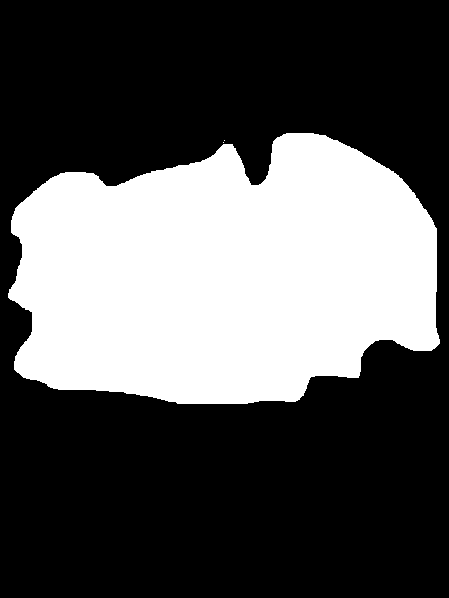

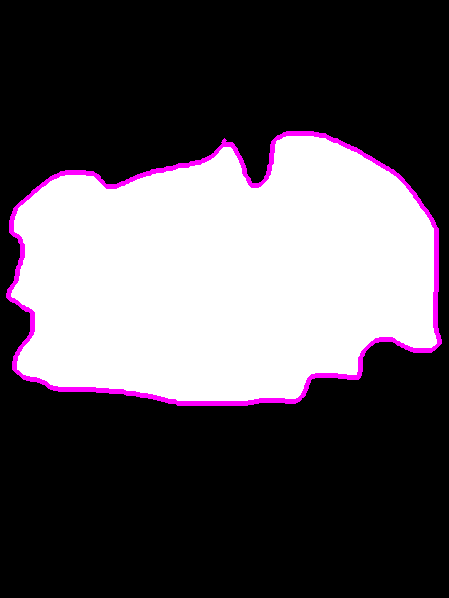

In [ ]:
import cv2 # Computer vision library
from google.colab.patches import cv2_imshow

# Read the color image
image = cv2.imread("/content/malignant_mask.png")

# Make a copy
new_image = image.copy()
cv2_imshow(new_image)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

# Find the contours on the inverted binary image, and store them in a list
# Contours are drawn around white blobs.
# hierarchy variable contains info on the relationship between the contours
contours, hierarchy = cv2.findContours(new_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
# Draw the contours (in red) on the original image and display the result
# Input color code is in BGR (blue, green, red) format
# -1 means to draw all contours
with_contours = cv2.drawContours(image, contours, -1,(255,0,255),3)
cv2_imshow(with_contours)
# # Show the total number of contours that were detected
# print('Total number of contours detected: ' + str(len(contours)))
# print(contours)
#  # Draw just the first contour
# # The 0 means to draw the first contour
# first_contour = cv2.drawContours(new_image, contours, 0,(255,0,255),3)
# cv2_imshow(first_contour)
# # Draw a bounding box around the first contour
# # x is the starting x coordinate of the bounding box
# # y is the starting y coordinate of the bounding box
# # w is the width of the bounding box
# # h is the height of the bounding box
# x, y, w, h = cv2.boundingRect(contours[0])
# cv2.rectangle(first_contour,(x,y), (x+w,y+h), (255,0,0), 5)
# cv2_imshow(first_contour)
# # Draw a bounding box around all contours
# for c in contours:
#   x, y, w, h = cv2.boundingRect(c)
#     # Make sure contour area is large enough
#   if (cv2.contourArea(c)) > 10:
#     cv2.rectangle(with_contours,(x,y), (x+w,y+h), (255,0,0), 5)

# cv2_imshow(with_contours)
